TODO: tester et demander si c'est un problème de précision que ça converge pas


    Iterate Helmhotz: phi_i = -2H[V*phi_i]
    Orthogonalize output orbitals with phi_i = sum_j [S^(-1/2)]_ij phi_j (Lowdin) matrix
    Compute Fock matrix in the orthogonalized set F_ij = <phi_i| T + V |phi_j>
    Diagonalize the Fock matrix: epsilon = U*F*U^T
    Apply the same transformation on the orbitals: phi_i = sum_j U_ji phi_j


Compute the overlap matrix $S^n_{i,j} = <\phi^n_{i}|\phi^n_{j}> $

In [27]:
def computeOverlap(phi_prev, pert_order = 0):
    S = np.zeros((nOrb, nOrb)) #Overlap matrix S_i,j = <Phi^i|Phi^j>
    for i in range(nOrb):
        for j in range(i, nOrb):
            S[i,j] = vp.dot(phi_prev[i][-1][pert_order], phi_prev[j][-1][pert_order]) #compute the overlap of the current ([-1]) step
            if i != j:
                S[j,i] = np.conjugate(S[i,j])
    return S

In [28]:
def orthonormalise(phi_prev, pert_order = 0): #Lödwin orthogonalisation and normalisation
    S = computeOverlap(phi_prev, pert_order)
    # print("S= ",S)
    #Diagonalise S to compute S' := S^-1/2 
    eigvals, U = np.linalg.eigh(S) #U is the basis change matrix
    
    # # print("EIGVALS=", eigvals, np.power(eigvals, -0.5))
    # print("U = ", U)
    # print("S = ", S)
    # s = np.diag(eigvals)
    # # print("False S = ", np.dot(np.transpose(U),np.dot(s,U))) # S^-1/2 = U^dagger s^-1/2 U (Note: transpose doesn't conjugate the matrix but it's a real matrix so whatever)
    # print("False S = ", np.dot(U,np.dot(s,np.transpose(U)))) # S^-1/2 = U^dagger s^-1/2 U

    s = np.diag(np.power(eigvals, -0.5)) #diagonalised S 
    #Compute s^-1/2
    # s = np.power(s, -0.5) #element-wise power operator
    # print(s)
    # Sprime = np.dot(np.transpose(U),np.dot(s,U)) # S^-1/2 = U^dagger s^-1/2 U
    Sprime = np.dot(U,np.dot(s,np.transpose(U))) # S^-1/2 = U^dagger s^-1/2 U
    # print(Sprime)

    #Apply S' to each orbital to obtain a new orthogonal element
    phi_ortho = []
    # limit = [1, 2, 5, 5, 5]
    for i in range(nOrb):
        phi_tmp =  P_eps(Fzero)
        for j in range(nOrb):
        # for j in range(limit[i]):
            phi_tmp = phi_tmp + Sprime[i,j]*phi_prev[j][-1][pert_order]
        phi_tmp.normalize()
        phi_ortho.append(phi_tmp)
    #Now replace the non-orthonormal orbitals with an orthonormal one 
    for i in range(nOrb):
        phi_prev[i][-1][pert_order] = phi_ortho[i]

    #The orbitals are now orthonormalized
    #Now we can easily compute the Fock matrix to improve convergence speed
    # for k in range(nOrb):
    #     for l in range(nHistory):
    #         computeFockMat(phi_)
    
    # print("Babawiwiwiwiwiwiwiwiw" ,vp.dot(phi_prev[0][-1],phi_prev[1][-1]))
    return phi_prev
    

In [29]:
def compDensity(phi_ket, phi_bra, pert_order=0): #computes an element of the (perturbed) density matrix
    print(type(phi_ket[-1][0]), type(phi_bra[-1][pert_order]))
    # print("compDensity", type(phi_ket[-1][0]*phi_bra[-1][pert_order] ))
    rho = phi_ket[-1][0]*phi_bra[-1][pert_order] 
    if pert_order == 1:
        rho += phi_bra[-1][pert_order]*phi_ket[-1][0]
        # print("compDensity", type(rho))
    return rho


In [30]:
def printDebug(phi_prev, i, j, Vnuc, J, K, p_ord = 0):
    Divphi_n = D(D(phi_prev[i][-1][p_ord], 0), 0) + D(D(phi_prev[i][-1][p_ord], 1), 1) + D(D(phi_prev[i][-1][p_ord], 2), 2) #Laplacian of the orbitals

    pTp = vp.dot(phi_prev[i][-1][p_ord], -0.5*Divphi_n)
    pJp = vp.dot(phi_prev[i][-1][p_ord], J*phi_prev[j][-1][p_ord]) #<phi_n|T|phi_n> -- Kinetic energy
    pVp = vp.dot(phi_prev[i][-1][p_ord], Vnuc*phi_prev[j][-1][p_ord]) # Potential Energy
    pKp = vp.dot(phi_prev[i][-1][p_ord], K[j]) # Potential Energy

    print(" T=", pTp," Vnuc=", pVp," J=", pJp," K=", pKp)

In [31]:
def compFock(phi_prev, pert_order = 0, orb_order = 0): 
    #pert_order determines if the order of perturbation of the Fock operator, orb_order is used in case we need to use a specific perturbed orbital in the computations
    V = Vnuc 
    Fock = np.zeros((nOrb, nOrb))
    K = []
    J = computeCoulombPot(phi_prev, pert_order)
    for j in range(nOrb):
        #Compute the potential operator
        K.append(computeExchangePotential(phi_prev, j, pert_order))
        # V = Vnuc
        # compute the energy from the orbitals 
        #Laplacian of the orbitals, even at 1st pertub order it's only applied to unperturbed orbitals
        Divphi_n = D(D(phi_prev[j][-1][orb_order], 0), 0) + D(D(phi_prev[j][-1][orb_order], 1), 1) + D(D(phi_prev[j][-1][orb_order], 2), 2) 
        for i in range(nOrb):
            pTp = vp.dot(phi_prev[i][-1][orb_order],-0.5*Divphi_n) #<phi_n|T|phi_n> -- Kinetic energy
            
            pVp = vp.dot(phi_prev[i][-1][orb_order], V*phi_prev[j][-1][orb_order] + J*phi_prev[j][-1][orb_order] - K[j]) # Potential Energy
            Fock[i, j] = pTp + pVp 
    return Fock, V, J, K

In [32]:
def computeCoulombPot(phi_prev, pert_order=0): 
    # P = vp.PoissonOperator(mra, )
    # PNbr = 4*np.pi*phi_prev[0][-1]*phi_prev[0][-1]
    PNbr = 4*np.pi*compDensity(phi_prev[0],phi_prev[0], pert_order)
    for orb in range(1, nOrb):
        # PNbr = PNbr + 4*np.pi*phi_prev[orb][-1]*phi_prev[orb][-1]
        PNbr = PNbr + 4*np.pi*compDensity(phi_prev[0],phi_prev[0], pert_order)
    return Pois(2*PNbr) #factor of 2 because we sum over the number of orbitals, not electrons

# def computeCoulombPot(phi_prev, idx): 
#     # P = vp.PoissonOperator(mra, )
#     return Pois(4*np.pi*phi_prev[idx][-1]*phi_prev[idx][-1])

In [33]:
def computeExchangePotential(phi_prev, idx, pert_order=0, orb_order = 0): #Here orb_order defines the perturbation order on which we apply K, whose perturbation order is defined by pert_order
    print("CompExchPot" , phi_prev[0][-1][1], orb_order)
    K = phi_prev[0][-1][orb_order]*Pois(4*np.pi*compDensity(phi_prev[0],phi_prev[idx], pert_order))
    for j in range(1, nOrb):
        # K = K + phi_prev[j][-1]*Pois(4*np.pi*phi_prev[j][-1] * phi_prev[idx][-1])
        K = K + phi_prev[j][-1][orb_order]*Pois(4*np.pi*compDensity(phi_prev[j],phi_prev[idx], pert_order))
    return K 

# def computeExchangePotential(phi_prev, j, i): #Kj|phi_i>
#     return Pois(4*np.pi*phi_prev[j][-1] * phi_prev[i][-1]) * phi_prev[j][-1]

In [34]:
import numpy as np
l = 2.0541321496 #108.7 pm
angle = 1.91113553 #radians

def spherical_to_cartesian(radius, theta, phi): #thx chatgpt
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return x, y, z

C0 = np.array([.1, .1, .1])
H1 = C0 + np.array(spherical_to_cartesian(l, 0, 0))
H2 = C0 + np.array(spherical_to_cartesian(l, angle, 0)) 
H3 = C0 + np.array(spherical_to_cartesian(l, angle, angle)) 
H4 = C0 + np.array(spherical_to_cartesian(l, angle, -angle)) 

print(C0)
print(H1)
print(H2)
print(H3)
print(H4)

[0.1 0.1 0.1]
[0.1        0.1        2.15413215]
[ 2.03631019  0.1        -0.5856834 ]
[-0.54635362  1.92524633 -0.5856834 ]
[-0.54635362 -1.72524633 -0.5856834 ]


In [35]:
from vampyr import vampyr3d as vp
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

prec = 1.0e-4

world = vp.BoundingBox(corner=[-1]*3, nboxes=[2]*3, scaling=[1.0]*3, scale= -4)
mra = vp.MultiResolutionAnalysis(order=6, box=world)
print(mra)


P_eps = vp.ScalingProjector(mra, prec) 
Pois = vp.PoissonOperator(mra, prec)
#Derivative operator
D = vp.ABGVDerivative(mra, a=0.5, b=0.5)

r_x = np.linspace(-16, 16, 10000) # create an evenly spaced set of points between -0.99 and 0.99
r_y = np.linspace(-16, 16, 10000)
r_z = np.linspace(-16, 16, 10000)
# r_y = np.zeros(1000)
# r_z = np.zeros(1000)
r = [r_x, r_y, r_z]


# Analytic nuclear potential
# print("pouet")
#LiH
# R, Z, pathMol, nOrb = [[1.508001,  0.188973, 0.188973], [-1.508001,  0.188973, 0.188973]], [3,1], "/home/qpitto/Tests_KAIN/test_LiH/norun/orbitals/phi_p_scf_", 2 #LiH
#Ne
# R, Z, pathMol, nOrb = [[0.100, 0.100, 0.100]], [10], "/home/qpitto/Tests_KAIN/test_Ne/norun/orbitals/phi_p_scf_", 5 #Ne
#H2O
# R, Z, pathMol, nOrb = [[0.0000,  0.000, -0.125], [-1.4375,  0.000,  1.025], [1.4375,  0.000,  1.025]], [8,1,1], "/home/qpitto/Tests_KAIN/initial_guesses/phi_p_scf_", 5 #H2O
#CH4
R, Z, pathMol, nOrb = [[0.1, 0.1, 0.1], [0.1, 0.1, 2.15413215], [2.03631019, 0.1, -0.5856834], [-0.54635362, 1.92524633, -0.5856834], [-0.54635362, -1.72524633, -0.5856834]], [6,1,1,1,1], "/home/qpitto/Tests_KAIN/test_CH4/norun/orbitals/phi_p_scf_", 5 #CH4
nz = len(Z)

pert_ord = 1


def f_nuc(r):
    out = 0
    #electron-nucleus interaction
    for i in range(nz): 
        out += -Z[i]/np.sqrt((r[0]-R[i][0])**2 + (r[1]-R[i][1])**2 + (r[2]-R[i][2])**2) 
    return out

def f_NN():
    #nucleus-nucleus interaction
    out = 0
    # print("zblim")
    for i in range(nz-1):
        # print("zboum")
        for j in range(i+1, nz):
            # print(i, j)
            out += Z[i]*Z[j]/np.sqrt((R[j][0]-R[i][0])**2 + (R[j][1]-R[i][1])**2 + (R[j][2]-R[i][2])**2)
    return out 

# zero function
def Fzero(r):
    return 0.

def Id(r):
    return 1.


#Memory of KAIN
nHistory = 5

#Number of orbitals
# nOrb = 5

# #Closed shell (0: no, 1: yes)
# closedShell = 1

#Energy threshold
thrs = prec

# print("prout")
#Project the orbitals in the MR grid 
Vnuc =   P_eps(f_nuc)   # Project nuclear potential V from f_nuc


                    MultiResolution Analysis                    
----------------------------------------------------------------
 polynomial order      : 6
 polynomial type       : Interpolating
----------------------------------------------------------------
 total boxes           : 8
 boxes                 : [          2           2           2 ]
 unit lengths          : [  16.000000   16.000000   16.000000 ]
 scaling factor        : [   1.000000    1.000000    1.000000 ]
 lower bounds          : [ -16.000000  -16.000000  -16.000000 ]
 upper bounds          : [  16.000000   16.000000   16.000000 ]
 total length          : [  32.000000   32.000000   32.000000 ]



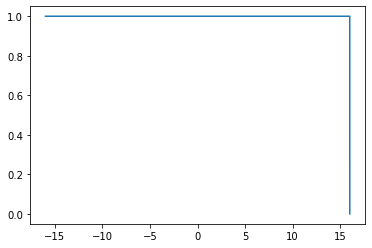

In [36]:
# #TODO: plot le potentiel nucléaire pour voir si c'est pas lui la cause du problème
Idprj = P_eps(Id)
Id_pltx = [Idprj([x, 0.0, 0.0]) for x in r_x]
# fnuc_plty = [Vnuc([0.0, y, 0.0]) for y in r_y]
# fnuc_pltz = [Vnuc([0.0, 0.0, z]) for z in r_z]
# plt.figure()
plt.plot(r_x, Id_pltx )
# plt.figure()
# plt.plot(r_y, fnuc_plty )
# plt.figure()
# plt.plot(r_z, fnuc_pltz )

In [37]:

#initial guesses provided by mrchem
phi_prev = []
for i in range(nOrb):
    #1st order perturbation initial guess 
    pert_tree = P_eps(Fzero)

    # print(i)
    ftree = vp.FunctionTree(mra)
    # print(f"/home/qpitto/Tests_KAIN/test_H2/norun/orbitals/phi_p_scf_idx_{i}_re")
    # ftree.loadTree(f"/home/qpitto/Tests_KAIN/test_LiH/run/orbitals/phi_p_scf_idx_{i}_re")#converged
    # ftree.loadTree(f"/home/qpitto/Tests_KAIN/test_LiH/norun/checkpoint/phi_scf_idx_{i}_re") #initial
    ftree.loadTree(f"{pathMol}idx_{i}_re") #initial
    phi_prev.append([[ftree, pert_tree]])
    # print(ftree)
    # print(phi_prev[i][-1].norm())

# phi_prev =  [[phi1],[phi2],[phi3],[phi4]] #list of previous steps for every orbitals
f_prev = [[[]] for i in range(nOrb)] #list of the corrections at previous steps
print(phi_prev)

[[[<vampyr._vampyr.vampyr3d.FunctionTree object at 0x7f963662a270>, <vampyr._vampyr.vampyr3d.FunctionTree object at 0x7f95b8815630>]], [[<vampyr._vampyr.vampyr3d.FunctionTree object at 0x7f95b8047d70>, <vampyr._vampyr.vampyr3d.FunctionTree object at 0x7f958c0d2bb0>]], [[<vampyr._vampyr.vampyr3d.FunctionTree object at 0x7f95be137770>, <vampyr._vampyr.vampyr3d.FunctionTree object at 0x7f958c084030>]], [[<vampyr._vampyr.vampyr3d.FunctionTree object at 0x7f958c084330>, <vampyr._vampyr.vampyr3d.FunctionTree object at 0x7f95be1abe70>]], [[<vampyr._vampyr.vampyr3d.FunctionTree object at 0x7f95b885ea30>, <vampyr._vampyr.vampyr3d.FunctionTree object at 0x7f95b885e5b0>]]]


In [38]:
# phi_prev = orthonormalise(phi_prev)
# print("S = ", computeOverlap(phi_prev))


#Seperating the orbitals back to cannonical orbitals, because orthonormalisation may have scrambled them
# phi_prev, f_prev = applyFock(phi_prev, f_prev)

F, V, J, K = compFock(phi_prev, 0) #0 is the perturbation order

print(type(F))

#Energies of each orbital
E_n = []
#internal nuclear energy
E_pp = f_NN()
# Prepare Helmholtz operators
G_mu = []
# J = computeCoulombPot(phi_prev)
for i in range(nOrb):
    # print(phi_prev[i][-1].norm())
    # #Compute the potential operator
    # K = computeExchangePotential(phi_prev, i)
    # V = Vnuc + J
    # # V = Vnuc
    # # compute the energy from the orbitals 
    # Divphi_n = D(D(phi_prev[i][-1], 0), 0) + D(D(phi_prev[i][-1], 1), 1) + D(D(phi_prev[i][-1], 2), 2) #Laplacian of the orbitals
    # pTp = vp.dot(phi_prev[i][-1],-0.5*Divphi_n) #<phi_n|T|phi_n> -- Kinetic energy
    # pVp = vp.dot(phi_prev[i][-1], V*phi_prev[i][-1] - K) # Potential Energy
    # print("pouet=", vp.dot(phi_prev[i][-1],-0.5*Divphi_n) + vp.dot(phi_prev[i][-1], Vnuc*phi_prev[i][-1]))
    # print("pouet=", vp.dot(phi_prev[i][-1], K))
    # print("pouet=", vp.dot(phi_prev[i][-1], J*phi_prev[i][-1]))

    # pVp = vp.dot(phi_prev[i][-1], V*phi_prev[i][-1]) # Potential Energy
    # E_n.append(-(pTp + pVp)) # Current energy

    E_n.append(F[i,i])
    # E_n.append(2*F[i]+E_pp)

    mu = np.sqrt(-2*E_n[i])
    # mu = 1 #E = -0.5 analytical solution
    G_mu.append(vp.HelmholtzOperator(mra, mu, prec))  # Initalize the operator

    # print(phi_prev[i][-1])
    printDebug(phi_prev, i, i, V, J, K)
    
    print(vp.dot(phi_prev[i][-1][0], phi_prev[i][-1][0]))
print(E_n)
# print(f_NN())
# print("total energy",np.sum(2*E_n)+f_NN())

<class 'vampyr._vampyr.vampyr3d.FunctionTree'> <class 'vampyr._vampyr.vampyr3d.FunctionTree'>
<class 'vampyr._vampyr.vampyr3d.FunctionTree'> <class 'vampyr._vampyr.vampyr3d.FunctionTree'>
<class 'vampyr._vampyr.vampyr3d.FunctionTree'> <class 'vampyr._vampyr.vampyr3d.FunctionTree'>
<class 'vampyr._vampyr.vampyr3d.FunctionTree'> <class 'vampyr._vampyr.vampyr3d.FunctionTree'>
<class 'vampyr._vampyr.vampyr3d.FunctionTree'> <class 'vampyr._vampyr.vampyr3d.FunctionTree'>
CompExchPot 
*FunctionTree: nn
  genNodes: 0
  square norm: 0
  root scale: -4
  order: 6
  nodes: 8
  endNodes: 8
  nodes per scale: 
    scale=-4  nodes=8
 0
<class 'vampyr._vampyr.vampyr3d.FunctionTree'> <class 'vampyr._vampyr.vampyr3d.FunctionTree'>
<class 'vampyr._vampyr.vampyr3d.FunctionTree'> <class 'vampyr._vampyr.vampyr3d.FunctionTree'>
<class 'vampyr._vampyr.vampyr3d.FunctionTree'> <class 'vampyr._vampyr.vampyr3d.FunctionTree'>
<class 'vampyr._vampyr.vampyr3d.FunctionTree'> <class 'vampyr._vampyr.vampyr3d.FunctionT

<ipython-input-38-b8190f8be54f>:39: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(-2*E_n[i])


 T= 1.3863511925941372  Vnuc= -6.9708939393666505  J= 7.568633814227361  K= 0.92186181914107
0.9999999999999989
 T= 1.090254881536809  Vnuc= -6.192787847623368  J= 6.920676845994441  K= 0.7504910225618657
0.9999999999999548
 T= 1.0980948682256448  Vnuc= -6.169036347140519  J= 6.8850312535577425  K= 0.7507141429748869
0.999999999925477
 T= 1.109496867561272  Vnuc= -6.142796338305874  J= 6.928320470661255  K= 0.7349666724213417
0.9999999999996775
[11.45335621814203, 1.0622292483137794, 1.067652857346015, 1.0633756316679832, 1.1600543274953052]


In [39]:
#Compute the 1st order perturbed Fock matrix
if pert_ord == 1:
    F1, V1, J1, K1 = compFock(phi_prev, 1)

<class 'vampyr._vampyr.vampyr3d.FunctionTree'> <class 'vampyr._vampyr.vampyr3d.FunctionTree'>
<class 'vampyr._vampyr.vampyr3d.FunctionTree'> <class 'vampyr._vampyr.vampyr3d.FunctionTree'>
<class 'vampyr._vampyr.vampyr3d.FunctionTree'> <class 'vampyr._vampyr.vampyr3d.FunctionTree'>
<class 'vampyr._vampyr.vampyr3d.FunctionTree'> <class 'vampyr._vampyr.vampyr3d.FunctionTree'>
<class 'vampyr._vampyr.vampyr3d.FunctionTree'> <class 'vampyr._vampyr.vampyr3d.FunctionTree'>
CompExchPot 
*FunctionTree: nn
  genNodes: 0
  square norm: 0
  root scale: -4
  order: 6
  nodes: 8
  endNodes: 8
  nodes per scale: 
    scale=-4  nodes=8
 0
<class 'vampyr._vampyr.vampyr3d.FunctionTree'> <class 'vampyr._vampyr.vampyr3d.FunctionTree'>
<class 'vampyr._vampyr.vampyr3d.FunctionTree'> <class 'vampyr._vampyr.vampyr3d.FunctionTree'>
<class 'vampyr._vampyr.vampyr3d.FunctionTree'> <class 'vampyr._vampyr.vampyr3d.FunctionTree'>
<class 'vampyr._vampyr.vampyr3d.FunctionTree'> <class 'vampyr._vampyr.vampyr3d.FunctionT

Compute a first, temporary power iteration to create a KAIN history

In [40]:
#First compute the Fock matrix in order to apply the correct Helmholtz operator
# F = computeFockMatMolecule(phi_prev, J, closedShell)
# F = compFock(phi_prev)
I = P_eps(Id)

for orb in range(nOrb):

    #First establish a history (at least one step) of corrections to the orbital with standard iterations with Helmholtz operator to create
    for i in range(1):
        #Construct Sum_j!=i F_ij phi_j
        phi_tmp = P_eps(Fzero)
        for j in range(nOrb):
            if j != orb:
                phi_tmp = phi_tmp + F[orb, j]*phi_prev[j][i][0]
        # Apply Helmholtz operator to obtain phi_np1 #5
        # phi_np1 = -2*G_mu[orb](V*phi_prev[orb][i] - phi_tmp)
        phi_np1 = -2*G_mu[orb]((V + J)*phi_prev[orb][-1][0] - K[orb] - phi_tmp)
        # Compute update = ||phi^{n+1} - phi^{n}|| #6
        f_prev[orb].append([phi_np1 - phi_prev[orb][i][0]])

        # print(f_prev[orb][0].norm())
        print("pouet", orb)

        #First order perturbations
        if pert_ord == 1:
            #Construct Sum_j!=i F_ij phi_j
            phi1_tmp = P_eps(Fzero)
            for j in range(nOrb):
                if j != orb:
                    phi1_tmp = phi1_tmp - F[orb, j]*phi_prev[j][i][1]
            # Apply Helmholtz operator to obtain phi_np1 #5
            Tphi =  D(D(phi_prev[orb][-1][0], 0), 0) + D(D(phi_prev[orb][-1][0], 1), 1) + D(D(phi_prev[orb][-1][0], 2), 2)
            rho0 = compDensity(phi_prev[orb], phi_prev[orb],0) # unperturbed electron density
            print("boum")
            print(phi_prev)
            K0phi1 = computeExchangePotential(phi_prev,orb, 0, 1) #
            phi_np1 = -2*G_mu[orb]((V + J)*phi_prev[orb][-1][1] - K0phi1 - phi1_tmp + (I-rho0)*(Tphi + (V1 + J1)*phi_prev[orb][-1][0] - K1[orb]))
            # Compute update = ||phi^{n+1} - phi^{n}|| #6
            f_prev[orb].append([phi_np1 - phi_prev[orb][i][0]])

        #TODO à tester
        phi_np1.normalize()
        phi_prev[orb].append([[phi_np1]])
        if pert_ord == 1:
            phi_np1.normalize()
            phi_prev[orb][-1].append([phi_np1])


phi_prev = orthonormalise(phi_prev,0)
phi_prev = orthonormalise(phi_prev,1)
# print("S = ", computeOverlap(phi_prev))

pouet 0
<class 'vampyr._vampyr.vampyr3d.FunctionTree'> <class 'vampyr._vampyr.vampyr3d.FunctionTree'>
boum
[[[<vampyr._vampyr.vampyr3d.FunctionTree object at 0x7f963662a270>, <vampyr._vampyr.vampyr3d.FunctionTree object at 0x7f95b8815630>]], [[<vampyr._vampyr.vampyr3d.FunctionTree object at 0x7f95b8047d70>, <vampyr._vampyr.vampyr3d.FunctionTree object at 0x7f958c0d2bb0>]], [[<vampyr._vampyr.vampyr3d.FunctionTree object at 0x7f95be137770>, <vampyr._vampyr.vampyr3d.FunctionTree object at 0x7f958c084030>]], [[<vampyr._vampyr.vampyr3d.FunctionTree object at 0x7f958c084330>, <vampyr._vampyr.vampyr3d.FunctionTree object at 0x7f95be1abe70>]], [[<vampyr._vampyr.vampyr3d.FunctionTree object at 0x7f95b885ea30>, <vampyr._vampyr.vampyr3d.FunctionTree object at 0x7f95b885e5b0>]]]
CompExchPot 
*FunctionTree: nn
  genNodes: 0
  square norm: 0
  root scale: -4
  order: 6
  nodes: 8
  endNodes: 8
  nodes per scale: 
    scale=-4  nodes=8
 1
<class 'vampyr._vampyr.vampyr3d.FunctionTree'> <class 'vampyr.

TypeError: can't multiply sequence by non-int of type 'vampyr._vampyr.vampyr3d.FunctionTree'

In [ ]:
def setuplinearsystem(phi_prev_orb, f_prev_orb, pert_order = 0):
    lenHistory = len(phi_prev_orb)
    # print(lenHistory)
    # Compute matrix A
    A = np.zeros((lenHistory-1, lenHistory-1))
    b = np.zeros(lenHistory-1)
    for l in range(lenHistory-1):  
        # b[l] = -vp.dot(phi_prev_orb[l] - phi_prev_orb[-1], f_prev_orb[-1]) #work-ish
        dPhi = phi_prev_orb[l][pert_order] - phi_prev_orb[-1][pert_order]
        b[l] = vp.dot(dPhi, f_prev_orb[-1][pert_order])
        for j in range(lenHistory-1):
            # print(l, j)
            # A[l,j] = vp.dot(dPhi, f_prev_orb[j] - f_prev_orb[-1]) #FROM MRCHEM: the sign in the paper is wrong and this is correct #work-ish
            A[l,j] = -vp.dot(dPhi, f_prev_orb[j][pert_order] - f_prev_orb[-1][pert_order])
    
    # print("pouet" ,vp.dot(phi_prev_orb[0] - phi_prev_orb[-1], f_prev_orb[3] - f_prev_orb[-1]))

    #solve Ac = b for c
    # At = A.conjugate()
    # print(A.size)
    c = np.linalg.solve(A, b)
    return c

In [ ]:
# J = computeCoulombPot(phi_prev)
def expandSolution(phi_prev, f_prev, pert_order = 0): #Here phi_prev and f_prev are one orbital only, not the collection of all orbitals, but they include all their KAIN history and perturbations
    #Compute the fock matrix of the system
    F, V, J, K = compFock(phi_prev, pert_order) #TODO: changer le reste pour que ça corresponde avec ec nouveau formalisme
    
    phistory = []
    phistory1 = []
    E_n = []
    norm = []
    update = []
    for orb in range(nOrb):
        E_n.append(F[orb, orb])
        #Redefine the Helmholtz operator with the updated energy
        mu = np.sqrt(-2*E_n[orb])
        G_mu = vp.HelmholtzOperator(mra, mu, prec) 

        #Compute phi_tmp := Sum_{j!=i} F_ij*phi_j 
        phi_tmp = P_eps(Fzero)
        # print(nOrb, len(phi_prev))
        for orb2 in range(nOrb):
            #Compute off-diagonal Fock matrix elements
            # print("blam" ,*range(nOrb))
            if orb2 != orb:
                # print("tut",orb2, nOrb)
                phi_tmp = phi_tmp + F[orb, orb2]*phi_prev[orb2][-1][0]

        #Compute new power iteration for the Helmholtz operatort 
        phi_np1 = -2*G_mu((V + J)*phi_prev[orb][-1] - K[orb] - phi_tmp)

        #create an alternate history of orbitals which include the power iteration
        phistory.append([[phi_np1]])

        #First order perturbations
        phi1_tmp = P_eps(Fzero)
        if pert_ord == 1:
            #Construct Sum_j!=i F_ij phi_j
            phi1_tmp = P_eps(Fzero)
            for j in range(nOrb):
                if j != orb:
                    phi1_tmp = phi1_tmp - F[orb, j]*phi_prev[j][i][1]
            # Apply Helmholtz operator to obtain phi_np1 #5
            Tphi =  D(D(phi_prev[orb][-1][0], 0), 0) + D(D(phi_prev[orb][-1][0], 1), 1) + D(D(phi_prev[orb][-1][0], 2), 2)
            rho0 = compDensity(phi_prev[orb][-1][0], phi_prev[orb][-1][0],0) # unperturbed electron density
            K0phi1 = computeExchangePotential(phi_prev[orb][-1][0],orb, 0, 1) #
            phi_np1 = -2*G_mu[orb]((V + J)*phi_prev[orb][-1][1] - K0phi1 - phi1_tmp + (1-rho0)*(Tphi + (V1 + J1)*phi_prev[orb][-1][0] - K1[orb]))
            # Compute update = ||phi^{n+1} - phi^{n}|| #6
            
            phistory[-1].append(phi_np1)



    #Orthonormalise the alternate orbital history
    phistory = orthonormalise(phistory)
    if pert_order == 1: 
        phistory = orthonormalise(phistory, 1)
    # phi_prev = orthonormalise(phi_prev)

    for orb in range(nOrb):
        for pert in range(pert_order)
            f_prev[orb].append(phistory[orb][-1][pert] - phi_prev[orb][-1][pert])
            #Setup and solve the linear system Ac=b
            c = setuplinearsystem(phi_prev[orb], f_prev[orb], pert)
            # lenHistory = int(lenHistory)
            # print("Badabim" , lenHistory)

            #Compute the correction delta to the orbitals 
            # delta = computeNewCorrection(phi_prev[orb], f_prev[orb])
            # lenHistory = len(phi_prev[orb])
            # print(lenHistory)
            #compute the correction delta
            delta = f_prev[orb][-1][pert]
            for j in range(len(phi_prev[orb])-1):
                delta = delta + c[j]*(phi_prev[orb][j][pert] - phi_prev[orb][-1][pert] + f_prev[orb][j][pert] - f_prev[orb][-1][pert])

            #Apply correction
            phi_n = phi_prev[orb][-1][pert]
            phi_n = phi_n + delta

            #Normalize
            norm.append(phi_n.norm())
            phi_n.normalize()

            #Save new orbital
            if pert == 0:
                phi_prev[orb].append([phi_n])
            else:
                phi_prev[orb][0].append(phi_n)
        
        # #Without KAIN
        # phi_np1.normalize()
        # norm = phi_np1.norm()
        # phi_prev[orb].append(phi_np1)
        # delta = f_prev[orb][-1]

        #Correction norm (convergence metric)
        
        update.append(delta.norm())


    return phi_prev, f_prev, np.array(E_n), np.array(norm), np.array(update)


Multiple orbitals TODO: orthonormaliser les orbitales entre elles!

=============Iteration: 0
Orbital: 0    Norm: [0.99993132 1.00163698 1.00474314 1.00520506 1.0052069 ]    Update: [0.00373867 0.01445276 0.02099091 0.02094132 0.02374785]    Energy:[-11.2165101   -0.95821727  -0.58327189  -0.55878961  -0.51793736]
Orbital: 1    Norm: [0.99993132 1.00163698 1.00474314 1.00520506 1.0052069 ]    Update: [0.00373867 0.01445276 0.02099091 0.02094132 0.02374785]    Energy:[-11.2165101   -0.95821727  -0.58327189  -0.55878961  -0.51793736]
Orbital: 2    Norm: [0.99993132 1.00163698 1.00474314 1.00520506 1.0052069 ]    Update: [0.00373867 0.01445276 0.02099091 0.02094132 0.02374785]    Energy:[-11.2165101   -0.95821727  -0.58327189  -0.55878961  -0.51793736]
Orbital: 3    Norm: [0.99993132 1.00163698 1.00474314 1.00520506 1.0052069 ]    Update: [0.00373867 0.01445276 0.02099091 0.02094132 0.02374785]    Energy:[-11.2165101   -0.95821727  -0.58327189  -0.55878961  -0.51793736]
Orbital: 4    Norm: [0.99993132 1.00163698 1.00474314 1.00520506 1.0052069 ]    Update

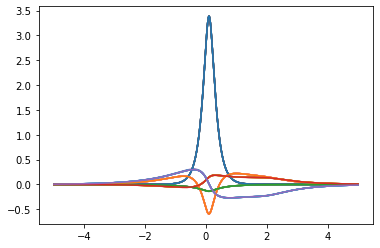

In [ ]:
# Optimization loop (KAIN)
# thrs = 1.0e-3
update = np.ones(nOrb)
norm = np.zeros(nOrb)
# phi_prev_U = phi_prev
i = 0
for pert in range(pert_ord):
    phi_prev = orthonormalise(phi_prev, pert)
# while (i < 12): # switch to (update > thrs) later
# J = computeCoulombPot(phi_prev)
while update.max() > thrs:
    print(f"=============Iteration: {i}")
    i += 1 

    # J = computeCoulombPot(phi_prev)
    for pert in range(pert_ord):
        phi_prev, f_prev, E_n, norm, update = expandSolution(phi_prev, f_prev, pert)
    # phi_prev, f_prev, E_n, norm, update = expandSolution_nokain(phi_prev, f_prev)

    for orb in range(nOrb):
        # phi_prev = orthonormalise(phi_prev)

        # print("Babawiw" ,vp.dot(phi_prev[0][-1],phi_prev[1][-1]))

    
        # this will plot the wavefunction at each iteration
        r_x = np.linspace(-5., 5., 1000)
        phi_n_plt = [phi_prev[orb][-1][0]([x, 0.0, 0.0]) for x in r_x]
        plt.plot(r_x, phi_n_plt) 
        

        if len(phi_prev[orb]) > nHistory: #deleting oldest element to save memory
            del phi_prev[orb][0]
            del f_prev[orb][0]
        print(f"Orbital: {orb}    Norm: {norm}    Update: {update}    Energy:{E_n}")
        # printDebug(phi_prev, orb, orb, Vnuc, J, K)
    # phi_prev = orthonormalise(phi_prev)
    for pert in range(pert_ord):
        phi_prev = orthonormalise(phi_prev, pert)
    
    # phi_prev, f_prev = applyFock(phi_prev, f_prev)

# plt.legend([f"iteration:{i} " for i in range(5)])

# plt.plot(r_x, [f_phi([x, 0., 0.]) for x in r_x], '.-', color='pink')

plt.show()



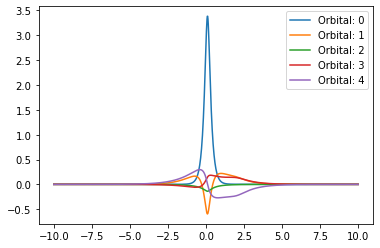

In [ ]:
r_x = np.linspace(-10., 10., 1000)
for orb in range(nOrb):
    phi_n_plt = [phi_prev[orb][-1]([x, 0.0, 0.0]) for x in r_x]
    plt.plot(r_x, phi_n_plt, label= f"Orbital: {orb}" )

plt.legend()
plt.show()